In [5]:
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from tensorflow.keras import backend as K
from custom_models.cnns import base_resnet50
from custom_models.augmentation import basic_augmentation, basic_plus_color_augmentation
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
import os


In [6]:
target_dir = '../../test_files/EGGIMazing/Dataset'
model_weights_directory = '../../experiments/logs'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5
name = f'resnet_binary_full_9_1{num_folds}'
model_fold_dir = sorted(os.listdir(model_weights_directory))
model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
              for x in model_fold_dir if x.startswith(name)]

In [7]:
model_dirs

['../../experiments/logs/resnet_binary_full_9_15fold_0_20240817-161243/weights.h5',
 '../../experiments/logs/resnet_binary_full_9_15fold_1_20240817-161411/weights.h5',
 '../../experiments/logs/resnet_binary_full_9_15fold_2_20240817-161547/weights.h5',
 '../../experiments/logs/resnet_binary_full_9_15fold_3_20240817-161717/weights.h5',
 '../../experiments/logs/resnet_binary_full_9_15fold_4_20240817-161850/weights.h5']

In [8]:
from etl.load_dataset import get_tf_eggim_full_image_dataset

n_classes = 2  # Replace with the number of classes you have
target_variable = 'eggim_global'
dp = DatasetProcessor(target_dir)
df = dp.process(merge_eggim_global=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)

split = dp.smarter_multiple_ds_group_k_splits(df_togas,
                                                  df_ipo,
                                                  k=num_folds,
                                                  train_size=0.9,
                                                  test_size=0.1,
                                                  internal_train_size=0.5,
                                                  target_variable=target_variable,
                                                  random_state=42)

y_preds = []
y_trues = []
for fold, (df_train, df_val, df_test) in enumerate(split):
    model = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),
                               AUC(name='auc')])

    name_fold = name + f'fold_{fold}'
    checkpoint_dir, callbacks = get_standard_callbacks(name_fold, learning_rate)
    tf_test_df = get_tf_eggim_full_image_dataset(df_test,
                                                 num_classes=n_classes,
                                                 preprocess_fn=tf.keras.applications.resnet.preprocess_input)
    tf_test_df = tf_test_df.batch(batch_size)
    # around 70 no class weight
    model.load_weights(model_dirs[fold])
    model.evaluate(tf_test_df)
    y_preds.append(model.predict(tf_test_df))
    y_trues.append(np.concatenate([y for (_, y) in tf_test_df]))

2024-08-17 16:26:30.326527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


1/1 [==============================] - 1s 519ms/step


In [9]:
from evaluation.metrics import specificity_per_class
from evaluation.metrics import sensitivity_per_class
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
metrics = []
for y_true, y_pred in zip(y_trues, y_preds):
    y_pred = [1 if y_ > 0.5 else 0 for y_ in y_pred ]
    conf_matrix = confusion_matrix(y_true, y_pred)

    metrics.append([accuracy_score(y_true, y_pred),
                    balanced_accuracy_score(y_true, y_pred),
                    sensitivity_per_class(conf_matrix),
                    specificity_per_class(conf_matrix),
                    conf_matrix])

In [10]:
acc = np.array([x[0] for x in metrics])
bal_acc = np.array([x[1] for x in metrics])
spec = np.array([x[2] for x in metrics])
sens = np.array([x[3] for x in metrics])
confs = np.array([x[4] for x in metrics])

In [11]:
acc, bal_acc, np.mean(sens,axis=1)

(array([0.81481481, 0.79310345, 0.73333333, 0.74193548, 0.5       ]),
 array([0.75      , 0.7745098 , 0.73205742, 0.75840336, 0.7       ]),
 array([0.75      , 0.7745098 , 0.73205742, 0.75840336, 0.7       ]))

/tmp/ipykernel_3895586/1032877647.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Acc.', 'Bal Acc.'])


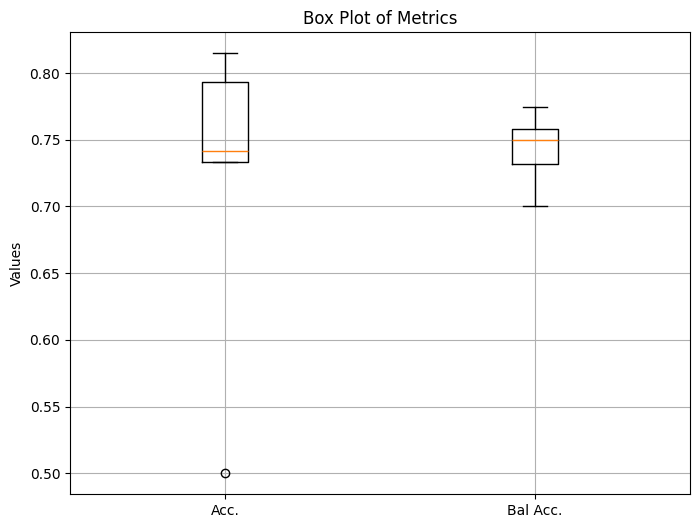

In [12]:
import matplotlib.pyplot as plt
data = [acc, bal_acc]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Acc.', 'Bal Acc.'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()